### LSTM model that predicts the closing price for the next four weeks
- multi-variable and multi-step model
- Convert to model input data format by taking care to avoid mixing comodities in one dataset
- Commodity code was used as an input variable,  
  and closing prices for 6 types of commodities were predicted with one model
- RMSE and MAPE are used as evaluation indicators

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

pd.options.mode.chained_assignment = None
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.float_format', '{:.2f}'.format)

### Read file
- The data to be worked on is downsampled from the raw data on a weekly basis.
- raw data name : Corn, Oat, Cereals & Grains Futures Data    
  (Historical data on Cereals and Grains Futures from Yahoo Finance)
- raw data source : kaggle datasets  
  (https://www.kaggle.com/datasets/guillemservera/grains-and-cereals-futures)

In [2]:
df = pd.read_csv('../data/grain_prices/all_grains_data_week_2.csv',
                sep=',', encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   commodity       7194 non-null   object 
 1   week_last_date  7194 non-null   object 
 2   open            7194 non-null   float64
 3   high            7194 non-null   float64
 4   low             7194 non-null   float64
 5   close           7194 non-null   float64
 6   volume          7194 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 393.5+ KB


In [3]:
# data sorting

df['week_last_date'] = pd.to_datetime(df['week_last_date'])
df.sort_values(by=['commodity', 'week_last_date'], inplace=True)

In [4]:
# Create year and month columns

df['Year'] = df['week_last_date'].dt.year

In [5]:
# commodity - Coded as an integer

df['commodity_code'] = df['commodity'].astype('category').cat.codes

mapping = dict(enumerate(df['commodity'].astype('category').cat.categories))
print(mapping)

{0: 'Corn', 1: 'KC HRW Wheat', 2: 'Oat', 3: 'Rough Rice', 4: 'Soybean', 5: 'Soybean Oil'}


In [6]:
# Select input variable

df1 = df[['week_last_date', 'commodity_code', 'Year', 'volume', 'close']]

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   week_last_date  7194 non-null   datetime64[ns]
 1   commodity_code  7194 non-null   int8          
 2   Year            7194 non-null   int32         
 3   volume          7194 non-null   int64         
 4   close           7194 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), int8(1)
memory usage: 203.9 KB


In [7]:
# normalization

df2 = df1.copy()

columns_to_scale = ['Year', 'volume', 'close']
sub_df = df2[columns_to_scale]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(sub_df)

df2[columns_to_scale] = scaled_values

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   week_last_date  7194 non-null   datetime64[ns]
 1   commodity_code  7194 non-null   int8          
 2   Year            7194 non-null   float64       
 3   volume          7194 non-null   float64       
 4   close           7194 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int8(1)
memory usage: 232.0 KB


In [8]:
# Separate test dataset

look_back = 10
forecast_horizon = 4

dates = df2['week_last_date'].unique()
sorted_dates = sorted(dates)

split_time = sorted_dates[-(look_back+forecast_horizon)]

train_data = df2[df2['week_last_date'] < split_time]
test_data = df2[df2['week_last_date'] >= split_time]

test_label = df1[df1['week_last_date'] >= split_time]
test_label = test_label[['commodity_code', 'week_last_date', 'close']]

train_data.drop(labels=['week_last_date'], axis=1, inplace=True)
test_data.drop(labels=['week_last_date'], axis=1, inplace=True)

In [9]:
# Function to convert input data format

def make_dataset(data, look_back, forecast_horizon):
    X, y = list(), list()
    for commodity_code, commodity_group in data.groupby('commodity_code'):
        
        for i in range(len(commodity_group)-look_back-forecast_horizon+1): 
            lag_end = i + look_back
            forecast_end = lag_end + forecast_horizon
            if forecast_end > len(commodity_group):
                break
            seq_x, seq_y = commodity_group[i:lag_end], commodity_group[lag_end:forecast_end]
            X.append(seq_x)
            y.append(seq_y)
            
    return np.array(X), np.array(y)

In [10]:
# train data - convert to input data format

trainX, trainY = make_dataset(train_data, look_back, forecast_horizon)
trainY = trainY[:, :, len(train_data.columns)-1:len(train_data.columns)]

# test data - convert to input data format

testX, testY = make_dataset(test_data, look_back, forecast_horizon)
testY = testY[:, :, len(train_data.columns)-1:len(train_data.columns)]

# test label - convert to input data format

testX_label, testY_label = make_dataset(test_label, look_back, forecast_horizon)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(testX_label.shape, testY_label.shape)

(7032, 10, 4) (7032, 4, 1)
(6, 10, 4) (6, 4, 1)
(6, 10, 3) (6, 4, 3)


In [11]:
# model building

tf.random.set_seed(7)

model = Sequential()

model.add(LSTM(128, activation='LeakyReLU', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='LeakyReLU'))
model.add(RepeatVector(trainY.shape[1]))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='LeakyReLU', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

adam1 = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam1, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           68096     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVecto  (None, 4, 64)             0         
 r)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 32)             12416     
                                                                 
 time_distributed (TimeDist  (None, 4, 1)              33        
 ributed)                                               

In [12]:
# model training

early_stop = EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(trainX, trainY, epochs=100,  
                 batch_size=8, validation_split=0.1, callbacks=[early_stop])

Epoch 1/100
791/791 [==============================] - 19s 18ms/step - loss: 0.0048 - mae: 0.0427 - val_loss: 4.5828e-05 - val_mae: 0.0054
Epoch 2/100
791/791 [==============================] - 12s 16ms/step - loss: 0.0015 - mae: 0.0267 - val_loss: 1.1383e-04 - val_mae: 0.0092
Epoch 3/100
791/791 [==============================] - 13s 16ms/step - loss: 0.0012 - mae: 0.0235 - val_loss: 2.5731e-04 - val_mae: 0.0149
Epoch 4/100
791/791 [==============================] - 12s 16ms/step - loss: 9.7640e-04 - mae: 0.0213 - val_loss: 2.0717e-04 - val_mae: 0.0127
Epoch 5/100
791/791 [==============================] - 13s 16ms/step - loss: 8.3731e-04 - mae: 0.0198 - val_loss: 8.3901e-05 - val_mae: 0.0076
Epoch 6/100
791/791 [==============================] - 13s 16ms/step - loss: 7.3248e-04 - mae: 0.0183 - val_loss: 2.4996e-04 - val_mae: 0.0145
Epoch 7/100
791/791 [==============================] - 13s 16ms/step - loss: 6.3751e-04 - mae: 0.0172 - val_loss: 2.2161e-04 - val_mae: 0.0136
Epoch 8/100

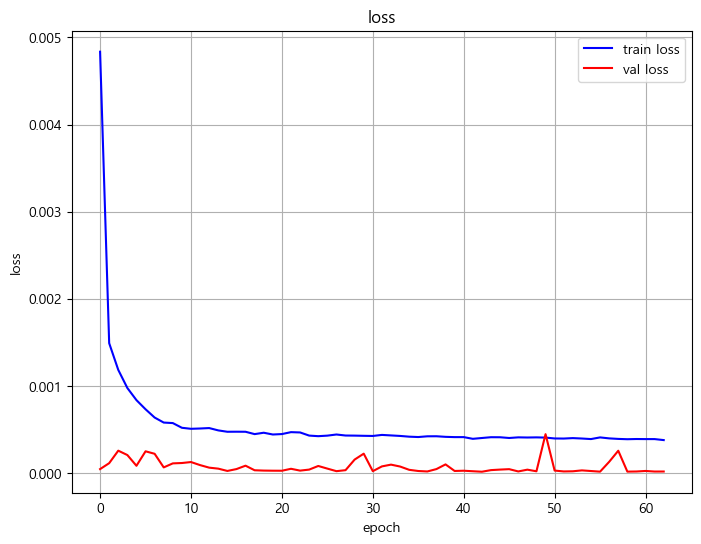

In [13]:
# show model training

plt.figure(figsize=(8, 6))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss', color='b')
plt.plot(hist.history['val_loss'], label='val loss', color='r')

plt.legend(loc='best')

plt.show()

In [14]:
def cal_MAPE(true, pred):
    return np.mean(np.abs((true - pred)/true))*100 

original_close_min = scaler.data_min_[columns_to_scale.index('close')]
original_close_range = scaler.data_range_[columns_to_scale.index('close')]

#### The test data prediction performance for each commodity is as follows:

1/1 [==============================] - 0s 54ms/step
RMSE: 45.809
MAPE: 9.544


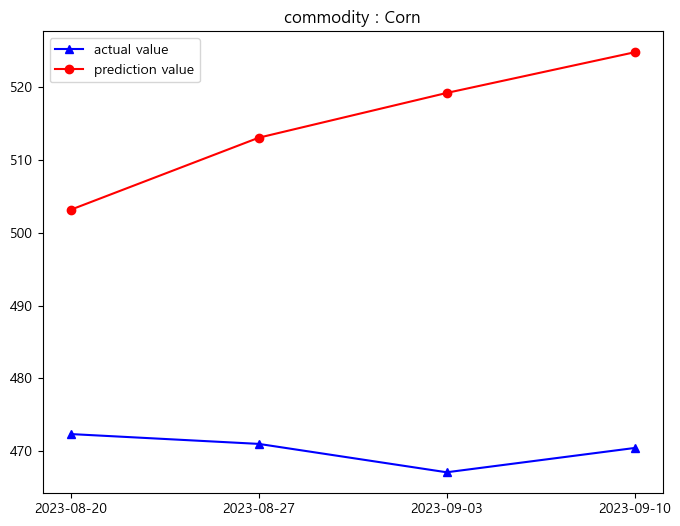

In [21]:
# test data prediction

i = 0
pred_i = model.predict(testX[i:i+1, :, :])
pred_i = pred_i[0, :, 0]
pred_i_inv = pred_i * original_close_range + original_close_min

# True value

commodity_i = testY_label[i, 0, 0]
date_i = testY_label[i, :, 1]
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]
y_true_i = testY_label[i, :, 2]

# prediction evaluation
    
MSE_i = mean_squared_error(y_true_i, pred_i_inv)
RMSE_0 = np.sqrt(MSE_i)
MAPE_0 = cal_MAPE(y_true_i, pred_i_inv) 

print('RMSE: %.3f' %(RMSE_0))
print('MAPE: %.3f' %(MAPE_0)) 

# visualization

plt.figure(figsize=(8, 6))
plt.plot(date_i, y_true_i, label='actual value', color='b', marker='^')
plt.plot(date_i, pred_i_inv, label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[commodity_i]}")

plt.show()

1/1 [==============================] - 0s 37ms/step
RMSE: 51.513
MAPE: 6.840


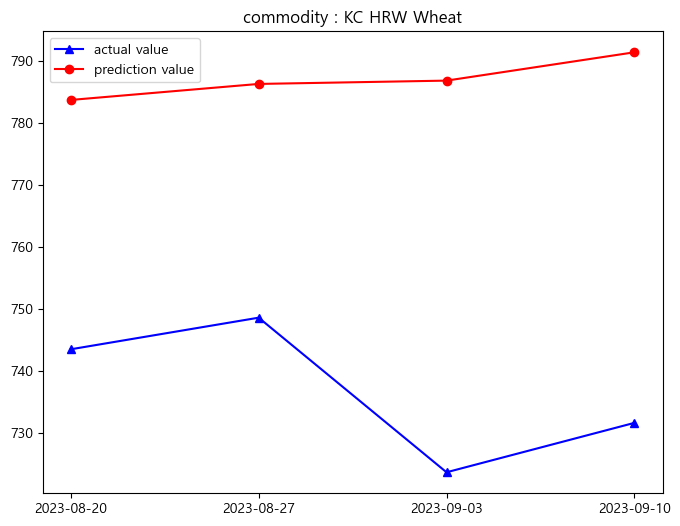

In [22]:
# test data prediction

i = 1
pred_i = model.predict(testX[i:i+1, :, :])
pred_i = pred_i[0, :, 0]
pred_i_inv = pred_i * original_close_range + original_close_min

# True value

commodity_i = testY_label[i, 0, 0]
date_i = testY_label[i, :, 1]
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]
y_true_i = testY_label[i, :, 2]

# prediction evaluation
    
MSE_i = mean_squared_error(y_true_i, pred_i_inv)
RMSE_1 = np.sqrt(MSE_i)
MAPE_1 = cal_MAPE(y_true_i, pred_i_inv) 

print('RMSE: %.3f' %(RMSE_1))
print('MAPE: %.3f' %(MAPE_1)) 

# visualization

plt.figure(figsize=(8, 6))
plt.plot(date_i, y_true_i, label='actual value', color='b', marker='^')
plt.plot(date_i, pred_i_inv, label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[commodity_i]}")

plt.show()

1/1 [==============================] - 0s 31ms/step
RMSE: 54.312
MAPE: 11.342


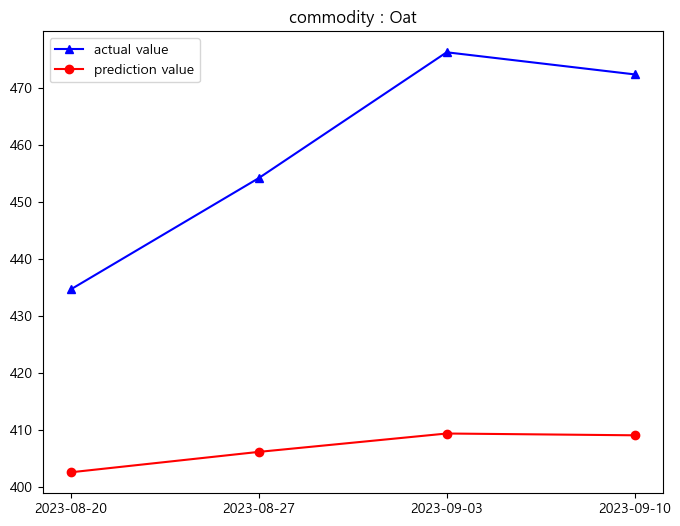

In [23]:
# test data prediction

i = 2
pred_i = model.predict(testX[i:i+1, :, :])
pred_i = pred_i[0, :, 0]
pred_i_inv = pred_i * original_close_range + original_close_min

# True value

commodity_i = testY_label[i, 0, 0]
date_i = testY_label[i, :, 1]
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]
y_true_i = testY_label[i, :, 2]

# prediction evaluation
    
MSE_i = mean_squared_error(y_true_i, pred_i_inv)
RMSE_2 = np.sqrt(MSE_i)
MAPE_2 = cal_MAPE(y_true_i, pred_i_inv) 

print('RMSE: %.3f' %(RMSE_2))
print('MAPE: %.3f' %(MAPE_2)) 

# visualization

plt.figure(figsize=(8, 6))
plt.plot(date_i, y_true_i, label='actual value', color='b', marker='^')
plt.plot(date_i, pred_i_inv, label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[commodity_i]}")

plt.show()

1/1 [==============================] - 0s 45ms/step
RMSE: 69.443
MAPE: 3.259


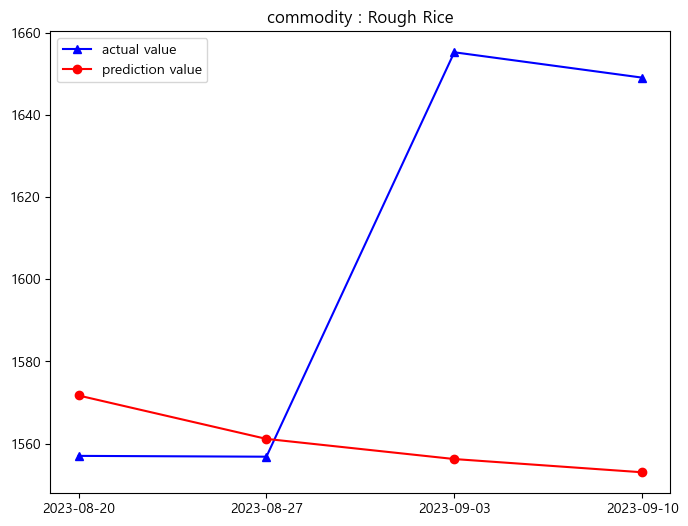

In [24]:
# test data prediction

i = 3
pred_i = model.predict(testX[i:i+1, :, :])
pred_i = pred_i[0, :, 0]
pred_i_inv = pred_i * original_close_range + original_close_min

# True value

commodity_i = testY_label[i, 0, 0]
date_i = testY_label[i, :, 1]
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]
y_true_i = testY_label[i, :, 2]

# prediction evaluation
    
MSE_i = mean_squared_error(y_true_i, pred_i_inv)
RMSE_3 = np.sqrt(MSE_i)
MAPE_3 = cal_MAPE(y_true_i, pred_i_inv) 

print('RMSE: %.3f' %(RMSE_3))
print('MAPE: %.3f' %(MAPE_3)) 

# visualization

plt.figure(figsize=(8, 6))
plt.plot(date_i, y_true_i, label='actual value', color='b', marker='^')
plt.plot(date_i, pred_i_inv, label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[commodity_i]}")

plt.show()

1/1 [==============================] - 0s 31ms/step
RMSE: 42.049
MAPE: 2.975


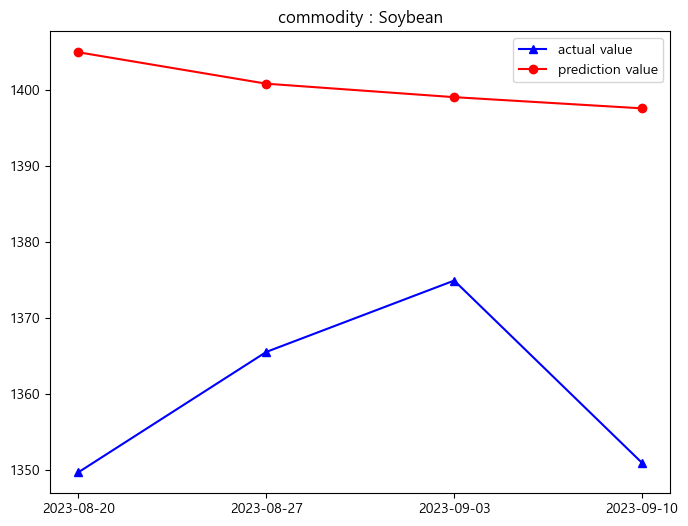

In [25]:
# test data prediction

i = 4
pred_i = model.predict(testX[i:i+1, :, :])
pred_i = pred_i[0, :, 0]
pred_i_inv = pred_i * original_close_range + original_close_min

# True value

commodity_i = testY_label[i, 0, 0]
date_i = testY_label[i, :, 1]
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]
y_true_i = testY_label[i, :, 2]

# prediction evaluation
    
MSE_i = mean_squared_error(y_true_i, pred_i_inv)
RMSE_4 = np.sqrt(MSE_i)
MAPE_4 = cal_MAPE(y_true_i, pred_i_inv) 

print('RMSE: %.3f' %(RMSE_4))
print('MAPE: %.3f' %(MAPE_4)) 

# visualization

plt.figure(figsize=(8, 6))
plt.plot(date_i, y_true_i, label='actual value', color='b', marker='^')
plt.plot(date_i, pred_i_inv, label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[commodity_i]}")

plt.show()

1/1 [==============================] - 0s 50ms/step
RMSE: 13.655
MAPE: 20.614


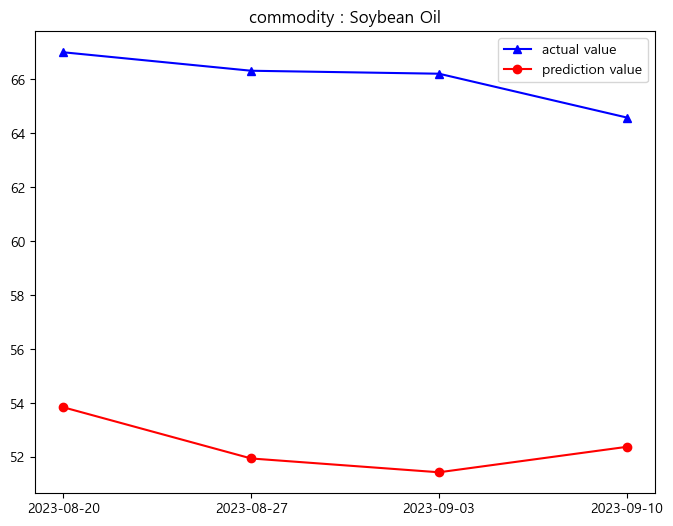

In [26]:
# test data prediction

i = 5
pred_i = model.predict(testX[i:i+1, :, :])
pred_i = pred_i[0, :, 0]
pred_i_inv = pred_i * original_close_range + original_close_min

# True value

commodity_i = testY_label[i, 0, 0]
date_i = testY_label[i, :, 1]
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]
y_true_i = testY_label[i, :, 2]

# prediction evaluation
    
MSE_i = mean_squared_error(y_true_i, pred_i_inv)
RMSE_5 = np.sqrt(MSE_i)
MAPE_5 = cal_MAPE(y_true_i, pred_i_inv) 

print('RMSE: %.3f' %(RMSE_5))
print('MAPE: %.3f' %(MAPE_5)) 

# visualization

plt.figure(figsize=(8, 6))
plt.plot(date_i, y_true_i, label='actual value', color='b', marker='^')
plt.plot(date_i, pred_i_inv, label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[commodity_i]}")

plt.show()

In [27]:
print('Total mean RMSE: %.3f' %(np.mean([RMSE_0, RMSE_1, RMSE_2, RMSE_3, RMSE_4, RMSE_5])))
print('Total mean MAPE: %.3f' %(np.mean([MAPE_0, MAPE_1, MAPE_2, MAPE_3, MAPE_4, MAPE_5]))) 

Total mean RMSE: 46.130
Total mean MAPE: 9.096
